<a href="https://colab.research.google.com/github/fcoelhomrc/MachineLearning/blob/main/pytorch_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Tutorial

In this notebook, we will follow the [Pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html). The goals are simple:

- Learn the syntax to implement a training loop
- Learn the syntax to implement fully-connected networks and convolutional networks
- Revisit the LSMT notebook with this new knowledge

In [1]:
import torch
from torchvision.models import resnet18, ResNet18_Weights

In [2]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [3]:
prediction = model(data) # forward pass

In [4]:
loss = (prediction - labels).sum()
loss.backward() # backward pass

In [5]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [6]:
optim.step()

The Pytorch paradigm is the following. We use the package `torch.nn` to build neural networks, but their training depends on using the `autograd` implementation.

Let's implement a convolutional network. 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

What is a `torch.nn.functional`? While `torch.nn` offers the class `nn.Module`, with certain attributes (e.g weights) and methods, `torch.nn.functional` offers the functions that perform usual deep learning computations. This allows for a more imperative programming style, since we work with stateless functions mainly.

In [8]:
# We always want to subclass nn.Module
class Net(nn.Module):
    # Here we should initialize every element of our network
    # without worry yet about their functionality
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5) # This syntax follows closely Tensorflow
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # We define only the forward method, which is called whenever we use Net(*args)
    # This is equivalent to implementing __call__ in a vanilla class
    # The backward method is defined automatically from this
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
# Retrieve learnable parameters
params = list(net.parameters()) 
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [10]:
type(params[0])

torch.nn.parameter.Parameter

Note that there is a `nn.parameter.Parameter` object that is used to store parameters in general.

Consider a random input image. Remember that the convention for Pytorch Tensor dimensions is (nSamples x nChannels x Height x Width)

In [11]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0677,  0.0729, -0.0913,  0.0248, -0.0007, -0.1007,  0.0087,  0.0761,
         -0.0320,  0.0898]], grad_fn=<AddmmBackward0>)


In [12]:
net.zero_grad() # Resets all gradient values to zero
out.backward(torch.randn(1, 10)) # Suppose a random gradient vector and backpropagate

In [13]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.7214, grad_fn=<MseLossBackward0>)


Let us follow `loss` computational graph in the backwards direction.

In [14]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

To backpropagate the error all we have to do is to `loss.backward()`. You need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

In [15]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0013,  0.0055, -0.0101, -0.0117, -0.0063,  0.0095])


Read more about the resources available in `torch.nn` [here](https://pytorch.org/docs/stable/nn.html).

For updating the weights, i.e training, we have the `torch.optim` package.

In [16]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

Note that when we instantiate an optimizer, we link it to our network through `net.parameters()`.

Remember to zero the gradient buffers, otherwise the gradient will be *accumulated* to the previous values.

# CIFAR10 with PyTorch

Specifically for image-based tasks, the package `torchvision` offers data loaders for common datasets (`torchvision.datasets`) and transformers (`torch.utils.data.DataLoader`).

In [17]:
import torchvision
import torchvision.transforms as transforms

In [23]:
# This remembers the Pipeline architecture of scikit-learn
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

# We can retrieve an already split train/test set

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


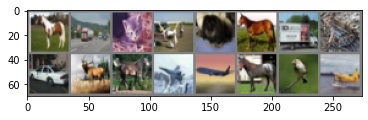

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

Notice that our `DataLoader` objects need to instantiated as *iterators*, and data batches can be sequentially retrieved with the `.next()` method.

I decided to implement a juicier CNN instead of just repeating the previous network.

In [76]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding="same") # inputs now have 3 channels
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding="same")
        self.fc1 = nn.Linear(16*8*8, 128) # Remember we will MaxPool twice, but padding conserves input shape otherwise
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x))) # Two convolutional layers, then MaxPool
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x))) # Two convolutional layers, then MaxPool
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1) # Softmax at output for multi-class prediction
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


Notice that when we create the layers, **we need to properly declare each input/output shape!** PyTorch doesn't infer the input shape from the previous output shape, like Tensorflow's `Sequential` API.

In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

We will now implement the **stardard training cycle, PyTorch-style.**

In [48]:
from tqdm import tqdm

n_epochs = 10
history = []
for epoch in range(n_epochs):  # loop over the dataset multiple times

    # Set up a progress bar, Tensforflow-style
    with tqdm(trainloader, unit="batch") as tepoch:

        running_loss = 0.0
        running_accuracy = 0.0
        # load each minibatch
        for data, labels in tepoch:

            tepoch.set_description(f"Epoch {epoch}") # Customize progress bar

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # compute metrics
            predictions = outputs.argmax(dim=1, keepdim=True).squeeze() # see MD cell below
            correct = (predictions == labels).sum().item()
            accuracy = correct / batch_size

            # save statistics for plotting
            running_loss += loss.item()
            running_accuracy += accuracy

            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy) # Display metrics
    
        # Save statistics for each epoch
        running_accuracy /= batch_size
        history.append([running_loss, running_accuracy])

print('Finished Training')

Epoch 9: 100%|██████████| 3125/3125 [01:01<00:00, 50.62batch/s, accuracy=0.438, loss=2.02]

Finished Training


A note about the previous code.

Our model predicts each class probability, but we want the predicted labels in order to compare with the target. 

This can be done by retrieving the most probable label. This is neatly done by calling the `np.argmax` function, along the 10 output values for each sample in the minibatch (thus `axis=1`).

Finally, `torch.squeeze` is a method that removes every unit dimension, e.g $(1, N, D, 1) \to (N, D)$. 

Also, `torch.item` returns a Tensor as a regular Python number.

More on the `tqdm` usage [here](https://adamoudad.github.io/posts/progress_bar_with_tqdm/).

In [51]:
history_arr = np.array(history).T
print(history_arr.shape)

(2, 10)


Text(0.5, 0.98, 'Training history')

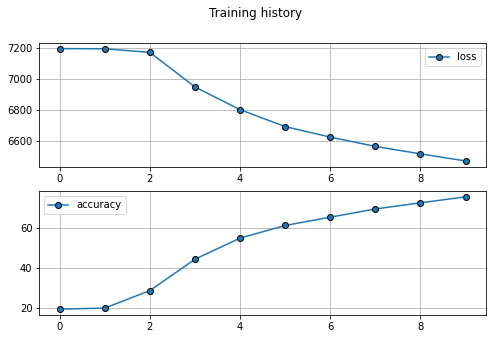

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5))
ax[0].plot([x for x in range(n_epochs)], history_arr[0], label="loss",
           marker="o", mec="k")
ax[1].plot([x for x in range(n_epochs)], history_arr[1], label="accuracy",
           marker="o", mec="k")
for i in range(2):
    ax[i].legend()
    ax[i].grid()
fig.suptitle("Training history")

Save our model...

In [63]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

...then load it.

In [64]:
my_net = Net()
my_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Now it remains to test our model

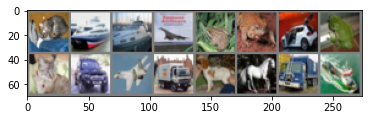

GroundTruth:  cat   ship  ship  plane


In [65]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [66]:
outputs = my_net(images)

In [68]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


Now run the above for the complete dataset.

In [70]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = my_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 38 %


This is better than random guessing (10% accuracy).

In [80]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = my_net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 46.1 %
Accuracy for class: car   is 39.8 %
Accuracy for class: bird  is 7.5 %
Accuracy for class: cat   is 26.3 %
Accuracy for class: deer  is 15.2 %
Accuracy for class: dog   is 26.8 %
Accuracy for class: frog  is 83.6 %
Accuracy for class: horse is 41.0 %
Accuracy for class: ship  is 57.0 %
Accuracy for class: truck is 37.3 %


Today, we learnt that frogs are simple animals, but birds are to be seen as utterly intricate machinery from nature.